# **Predicting Next Steps of a CFD Simulation using Deep Learning**

**Autores**: Janaína Gomide, Raquel Lobosco, Guilherme Antônio Santos

Universidade Federal do Rio de Janeiro

## Prepare Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os

folder_path = ""
sys.path.append(folder_path)

# Folder to database
folderDir = folder_path+"/"+"DataBaseFull"

## Import libraries



In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt

import pandas as pd

#Salvar e carregar gif
import glob
from PIL import Image

from ssim import ssim, SSIM

## CFD Simulation


1 - Simulação CFD realizada no Opem Foam

2 - Imagens geradas pelo ParaView


Acessar imagens geradas da simulação

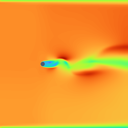

In [ ]:
# Image name
imagesPath = folderDir + "/Reynolds300/Reynolds300.0048.png"

# Opening the image
newsize = (128, 128)
img = Image.open(imagesPath).resize(newsize)
# Showing the image
img

## Pré-processamento


3 - Cortar imagens

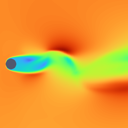

In [ ]:
# Image name
imagesPath = folderDir + "/Reynolds300/Reynolds300.0048.png"

# Opening the image
box = (285, 285, 669, 669)
newsize = (128, 128)
img2 = Image.open(imagesPath).crop(box).resize(newsize)
# Showing the image
img2

In [ ]:
def imageLoad(image):
    "Converts an image to an array and return it"
    return np.array(image)

4 - Preparar conjunto de dados

In [ ]:
# 3d array to hold the data
ImagesReynolds3D = []
# iterate over folders
labels = []
Reynolds = 90
MaxReynolds = 500
while(Reynolds <= MaxReynolds):
    # appending the Reynolds numbers as labels into the array label
    holder = []
    holder.append(Reynolds/MaxReynolds)
    labels.append(holder)
    # 2d array of size 10 to hold the images per reynolds number
    ImagesReynolds = []
    # importing and resizing to 128x128, all images from folder
    for filename in glob.glob(folderDir + "/Reynolds" + str(Reynolds) + "/*.png"):
        # opening the images and resizing them
        imageResized = Image.open(filename).crop(box).resize(newsize)
        # Appending an image to the 2d list
        ImagesReynolds.append(imageLoad(imageResized))

    # Appending the 2d image list to the 3d list of size 10
    ImagesReynolds3D.append(ImagesReynolds)
    #Increasing the Reynolds number
    Reynolds = Reynolds + 10
#ImagesReynolds3D

In [ ]:
ImagesReynolds3D = np.array(ImagesReynolds3D)
ImagesReynolds3D.shape

(42, 20, 128, 128, 3)

Visualizando conjunto de dados

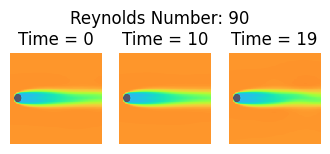

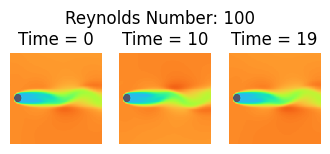

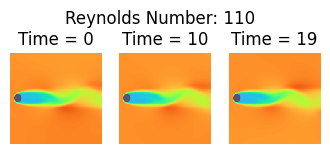

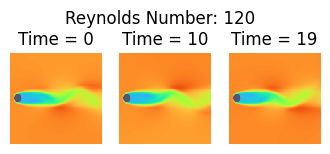

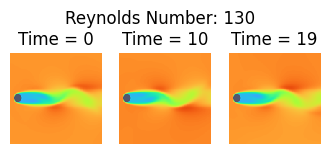

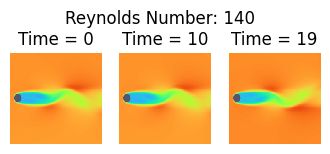

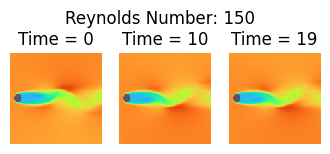

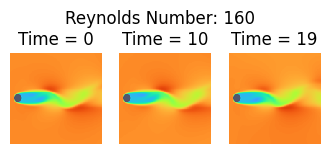

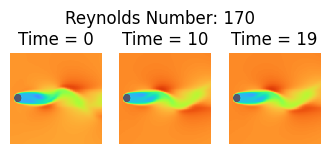

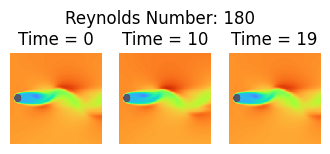

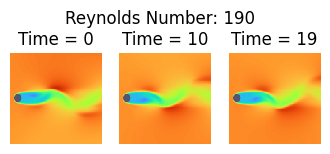

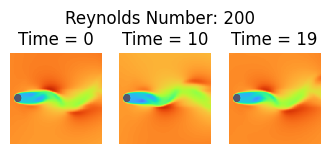

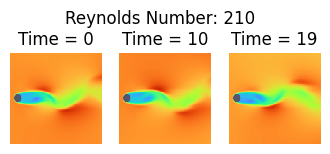

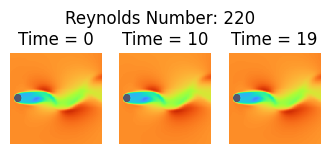

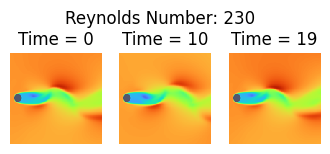

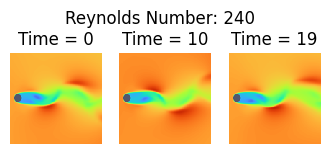

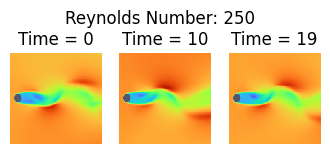

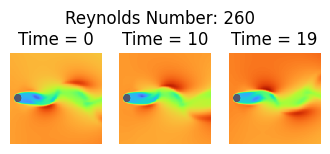

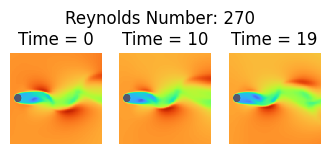

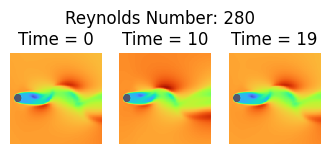

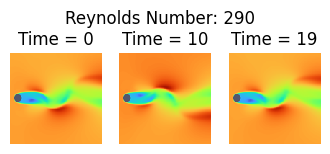

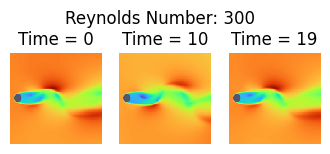

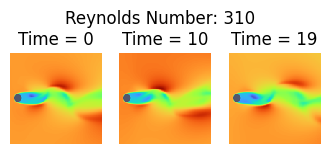

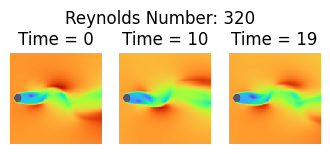

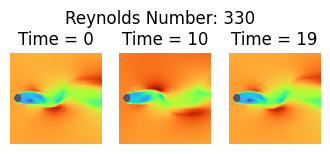

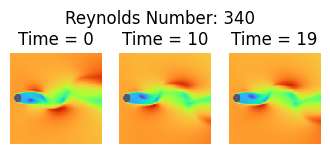

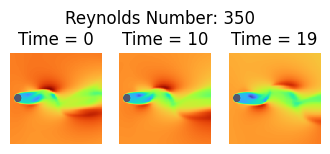

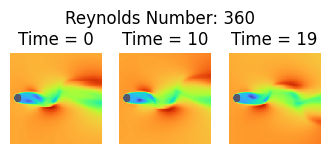

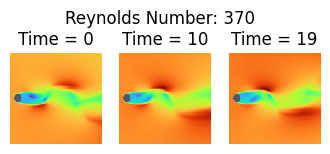

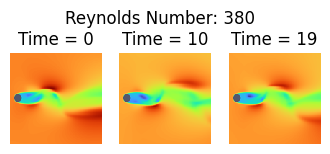

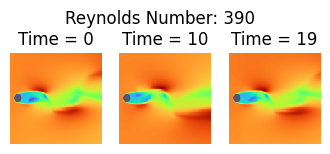

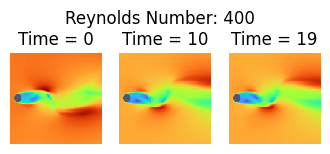

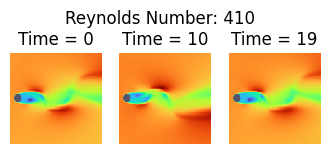

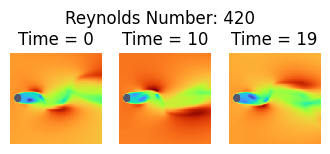

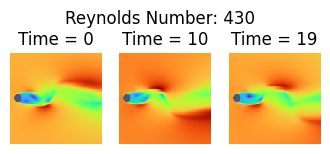

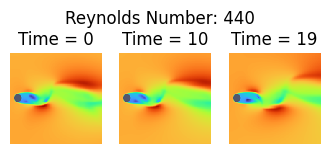

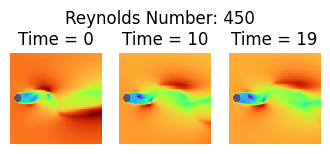

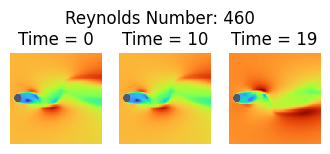

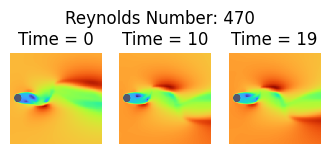

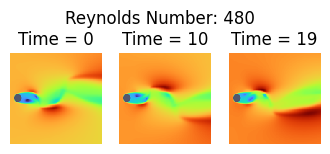

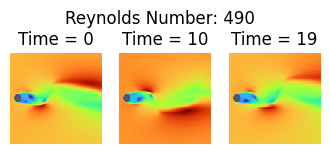

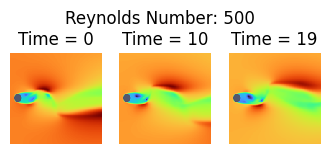

In [ ]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 4
boxSizeY = 1.84

# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3D)):
    # Setting the boxes sizes
    fig = plt.figure(figsize=[boxSizeX,boxSizeY])
    plt.suptitle("Reynolds Number: " + str(((10 + ReynoldsNumber)*10)-10))
    # Looping throuhg all times
    i = 1
    for time in range(len(ImagesReynolds3D[ReynoldsNumber])):
        if time == 0 or time == 10 or time == 19:
        # Subplotting every box with 11 timesteps for one example
            plt.subplot(1, 3, i)
            i = i + 1
            # Looping to open every image
            for image in ImagesReynolds3D[ReynoldsNumber][time]:
                plt.axis('off')
                # Showing every image stored in the array
                plt.imshow(ImagesReynolds3D[ReynoldsNumber][time], interpolation='nearest')
                # Plotting its images' time step
                plt.title('Time = %d'%int(time))
    plt.show()
    fig.savefig(folder_path+"/"+ folderDir +"/" + str(ReynoldsNumber+1) +".png", bbox_inches='tight')

Dividindo conjunto de dados em:


*   Treino
*   Validação
*   Teste

In [ ]:
# Shuffle Data
np.random.shuffle(ImagesReynolds3D)

# Train, Test, Validation splits
train_data = ImagesReynolds3D[:28]
val_data = ImagesReynolds3D[28:34]
test_data = ImagesReynolds3D[34:42]

In [ ]:
train_data.shape

(28, 20, 128, 128, 3)

In [ ]:
val_data.shape

(6, 20, 128, 128, 3)

In [ ]:
test_data.shape

(8, 20, 128, 128, 3)

## Deep Learning

In [ ]:
def collate(batch):

    # Move the channel dimension to the correct position
    # 0 - exemplos; 1 - tempo (sequencia de quadros);
    # 2 - altura; 3 - largura; 4 - canais de cores
    batch = np.transpose(batch, (0, 4, 1, 2, 3))

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch)
    batch = batch / 255.0 # scale pixels between 0 and 1
    batch = batch.to(device)

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)
    return batch[:,:,rand-10:rand], batch[:,:,rand]

In [ ]:
# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=7, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, batch_size=3, collate_fn=collate)

Visualizando as simulações como GIF

In [ ]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0

for video in input[:3]:          # Loop over videos
    video = video.transpose(1, 2, 3, 0)
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",duration=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))


5 - Criar Modelo Aprendizado Profundo - ConvLSTM

In [ ]:
# The input video frames are RGB, thus three channels
model = Seq2Seq(num_channels=3, num_kernels=128,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(128, 128), num_layers=1).to(device)

optim = Adam(model.parameters(), lr=1e-4)

#SSIM
ssim_loss = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=3, nonnegative_ssim=True)

In [ ]:
from torchsummary import summary
#(canais,tempo,altura,largura)
summary(model, (3, 10, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 512, 128, 128]         604,160
      ConvLSTMCell-2  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
            Conv2d-3        [-1, 512, 128, 128]         604,160
      ConvLSTMCell-4  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
            Conv2d-5        [-1, 512, 128, 128]         604,160
      ConvLSTMCell-6  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
            Conv2d-7        [-1, 512, 128, 128]         604,160
      ConvLSTMCell-8  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
            Conv2d-9        [-1, 512, 128, 128]         604,160
     ConvLSTMCell-10  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
           Conv2d-11        [-1, 512, 128, 128]         604,160
     ConvLSTMCell-12  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
 

6 - Treinar o modelo

**Escolha:**


1.   Carrega modelo já treinado
2.   Código para treinar o modelo (precisa de muita memória)



Carrega modelo treinado

In [ ]:
model = torch.load(folder_path+"/"+"modelRGB.pt")

Treinar o modelo

In [ ]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):

    train_loss = 0
    model.train()
    for batch_num, (input, target) in enumerate(train_loader, 1):
        output = model(input)
        _ssim_loss = 1 - ssim_loss(output, target)
        combined_loss = _ssim_loss
        combined_loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss += combined_loss.item()
    train_loss /= len(train_loader.dataset)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for input, target in val_loader:
            output = model(input)
            _ssim_loss = 1 - ssim_loss(output, target)
            combined_loss = _ssim_loss
            val_loss += combined_loss.item()
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("Epoch:{} Training Loss:{:.5f} Validation Loss:{:.5f}\n".format(epoch, train_loss, val_loss))



Salvar modelo que treinou

In [ ]:
saveModel = input("Save model?y/n").lower()
if saveModel == "y":
  nameModel = input("Please, write the name:")
  torch.save(model, folder_path+"/"+nameModel)

Visualizar as métricas obtidas no treino e na validação - Possível apenas quando treina modelo

In [ ]:
# Plot the training and validation losses
plt.figure()
# plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.rcParams['font.size'] = 20
plt.plot(range(1, num_epochs+1), train_losses, label='Treino', linewidth=4.5)
plt.plot(range(1, num_epochs+1), val_losses, label='Validação', linewidth=4.5)
plt.xlabel('Epoch')
plt.ylabel('Erro')

# plt.ylabel('Loss')
plt.legend()
#plt.title('Training and Validation Losses (SSIM)')

# Save the plot to a file
plt.savefig('loss_plot_ConvLSTM_RGB_SSIM.png', bbox_inches='tight')

# Print the arrays to save
print(train_losses)
print(val_losses)

# Display the plot
plt.show()

7 - Realiza previsão (Teste)

In [ ]:
debug = False
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,10:]
    if debug:
      target = np.array(batch)[:,10:12]

    batch = np.array(batch)

    # Move channel dim to the second position, scale pixels between 0 and 1, send to GPU
    batch = batch.transpose(0, 4, 1, 2, 3)  # Shape: (batch_size, 3, 20, 128, 128)
    batch = torch.tensor(batch)
    batch = batch / 255.0
    batch = batch.to(device)
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data, shuffle=True, batch_size=8, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))
print("Target shape:", target.shape)
print("Batch shape:", batch.shape)

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
# 8 9 10 11 12 13 14 15 16 17 18

for timestep in range(target.shape[1]):
    input = batch[:, :, timestep:timestep + 10]

    print("Input shape:", input.shape)

    # Process the input with the model and get the output
    model_output = model(input).cpu().detach().numpy() * 255.0

    # Transpose the model output to match the output array shape
    model_output = model_output.transpose(0, 2, 3, 1)

    # Assign the model output to the corresponding timestep in the output tensor
    output[:, timestep] = model_output
    print("Output shape:", output.shape)

Target shape: (8, 10, 128, 128, 3)
Batch shape: torch.Size([8, 3, 20, 128, 128])
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)
Input shape: torch.Size([8, 3, 10, 128, 128])
Output shape: (8, 10, 128, 128, 3)


Avalia os resultados (métricas: PSNR e SSIM)

In [ ]:
import os
import io
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from skimage.metrics import structural_similarity as ssim2
from sklearn.metrics import mean_squared_error

# Initialize a list to store SSIM values for all examples
all_ssim_values,all_psnr_values = [],[]

def psnr(target, output, max_pixel_value=255):
    mse = mean_squared_error(target.flatten(), output.flatten())
    if mse == 0:
        return 100
    return 20 * np.log10(max_pixel_value / np.sqrt(mse))

for idx, (tgt, out) in enumerate(zip(target, output)):  # Loop over samples

    # Calculate the SSIM between target and output
    tgt_frames = [np.array(frame) for frame in tgt]
    out_frames = [np.array(frame) for frame in out]
    win_size = min(min(tgt_frames[0].shape[:2]), 5)  # Choose an appropriate window size
    channel_axis = 2  # Set the channel axis for color images
    ssim_values = [ssim2(tgt_frame, out_frame, win_size=win_size, channel_axis=channel_axis) for tgt_frame, out_frame in zip(tgt_frames, out_frames)]
    avg_ssim = np.mean(ssim_values)

    # Calculate the MSE between target and output
    mse_values = [mean_squared_error(tgt_frame.flatten(), out_frame.flatten()) for tgt_frame, out_frame in zip(tgt_frames, out_frames)]
    avg_mse = np.mean(mse_values)

    # Calculate the PSNR between target and output GIFs
    psnr_values = [psnr(tgt_frame, out_frame) for tgt_frame, out_frame in zip(tgt_frames, out_frames)]
    avg_psnr = np.mean(psnr_values)

    # Append the SSIM and PSNR values for the current example to the lists
    all_ssim_values.append(ssim_values)
    all_psnr_values.append(psnr_values)

# Convert the list of SSIM and PSNR values to DataFrames
ssim_df, psnr_df= pd.DataFrame(all_ssim_values), pd.DataFrame(all_psnr_values)

# Calculate the average SSIM and PSNR for each example
ssim_df['Average'],psnr_df['Average']  = ssim_df.mean(axis=1), psnr_df.mean(axis=1)

# Transpose the DataFrames to display them vertically
ssim_df_transposed,psnr_df_transposed = ssim_df.T, psnr_df.T

# Add column names for better readability
ssim_df_transposed.columns = [f'Example {i}' for i in range(len(ssim_df_transposed.columns))]
psnr_df_transposed.columns = [f'Example {i}' for i in range(len(psnr_df_transposed.columns))]

# Print the SSIM and PSNR tables
print("SSIM Table:")
display(ssim_df_transposed)
print("PSNR Table:")
display(psnr_df_transposed)

ssim_df_transposed.to_csv('ssim_table.csv', index=False)
psnr_df_transposed.to_csv('psnr_table.csv', index=False)

# Calculate the standard deviation of the SSIM and PSNR values
ssim_std,psnr_std = ssim_df.std(axis=1), psnr_df.std(axis=1)


SSIM Table:


,Example 0,Example 1,Example 2,Example 3,Example 4,Example 5,Example 6,Example 7
0,0.629390,0.910739,0.711841,0.820007,0.759186,0.973988,0.717308,0.748298
1,0.811581,0.882478,0.840692,0.822213,0.832295,0.877127,0.871676,0.871378
2,0.868466,0.946551,0.713143,0.718289,0.805198,0.864109,0.804104,0.736989
3,0.675019,0.870509,0.811135,0.759001,0.836267,0.875720,0.733046,0.810871
4,0.794872,0.848162,0.801548,0.772315,0.789779,0.949364,0.768192,0.712490
5,0.860611,0.812118,0.741384,0.801492,0.753279,0.885050,0.748139,0.753142
6,0.866984,0.875307,0.631368,0.705555,0.840495,0.831012,0.818849,0.851330
7,0.780287,0.930393,0.735264,0.800458,0.802931,0.867804,0.686094,0.800804
8,0.770612,0.919746,0.827904,0.707380,0.821638,0.944955,0.717445,0.803955
9,0.870533,0.863219,0.692302,0.776668,0.815427,0.917643,0.747166,0.886447


PSNR Table:


,Example 0,Example 1,Example 2,Example 3,Example 4,Example 5,Example 6,Example 7
0,28.468485,29.987924,28.399725,29.370203,28.829584,32.774617,28.507764,29.442848
1,29.431451,30.102229,28.625284,30.050549,28.887988,29.447022,30.575316,30.339042
2,29.661533,32.444733,28.534870,28.550693,29.398741,29.344984,29.555527,28.457689
3,27.952354,30.002425,28.770512,29.025318,29.684252,29.092854,28.828102,29.732211
4,28.055565,29.056641,30.052332,29.198551,29.437868,32.406834,28.740612,28.631280
5,28.801821,28.884690,28.651370,29.019215,28.911678,29.602103,29.355959,28.724966
6,29.443733,29.310941,28.544341,28.993696,28.929991,28.783709,28.846948,29.899567
7,29.337623,30.885653,28.967556,29.109756,29.391577,28.852792,28.460626,29.199330
8,28.729445,31.323794,30.267427,28.714720,29.366239,32.299708,28.364590,28.920650
9,30.569952,29.721016,28.108339,28.312168,29.119852,31.162727,28.698163,30.113646


Visualiza os resultados

In [ ]:
for idx, (tgt, out) in enumerate(zip(target, output)):  # Loop over samples
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", duration=5)
        target_gif = gif.getvalue()
        imageio.mimsave(gif, out, "GIF", duration=5)
        output_gif = gif.getvalue()

    tgt_frames = [np.array(frame) for frame in tgt]
    out_frames = [np.array(frame) for frame in out]

    # Create error GIF
    error_frames = [np.abs(tgt_frame - out_frame) for tgt_frame, out_frame in zip(tgt_frames, out_frames)]
    with io.BytesIO() as gif:
        imageio.mimsave(gif, error_frames, "GIF", duration=5)
        error_gif = gif.getvalue()

    # Display the GIFs
    print("Test example: ",idx)
    display(widgets.HBox([widgets.Image(value=target_gif), widgets.Image(value=output_gif), widgets.Image(value=error_gif)]))

Test example:  0


Test example:  1


Test example:  2


Test example:  3


Test example:  4


Test example:  5


Test example:  6


Test example:  7


**Extra**:

Salvando imagens e gifs

In [ ]:
# Create directories if they don't exist
if not os.path.exists('saved_gifs'):
    os.makedirs('saved_gifs')

if not os.path.exists('saved_frames'):
    os.makedirs('saved_frames')

def save_gif(gif_data, filename, directory='saved_gifs'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(os.path.join(directory, filename), 'wb') as f:
        f.write(gif_data)

for idx, (tgt, out) in enumerate(zip(target, output)):  # Loop over samples
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", duration=5)
        target_gif = gif.getvalue()
        imageio.mimsave(gif, out, "GIF", duration=5)
        output_gif = gif.getvalue()

    # Save the GIFs
    save_gif(target_gif, f'target_RGB{idx}.gif')
    save_gif(output_gif, f'output_RGB{idx}.gif')

    tgt_frames = [np.array(frame) for frame in tgt]
    out_frames = [np.array(frame) for frame in out]

    # Create error GIF
    error_frames = [np.abs(tgt_frame - out_frame) for tgt_frame, out_frame in zip(tgt_frames, out_frames)]
    with io.BytesIO() as gif:
        imageio.mimsave(gif, error_frames, "GIF", duration=5)
        error_gif = gif.getvalue()

    # Save the error GIF
    save_gif(error_gif, f'error_RGB{idx}.gif')

    # Save the first and last frames of the output
    imageio.imsave(f'saved_frames/output_first_frame_{idx}.png', out_frames[0])
    imageio.imsave(f'saved_frames/output_last_frame_{idx}.png', out_frames[-1])

    # Save the first and last frames of the target
    imageio.imsave(f'saved_frames/target_first_frame_{idx}.png', tgt_frames[0])
    imageio.imsave(f'saved_frames/target_last_frame_{idx}.png', tgt_frames[-1])

    # Save the first and last frames of the error
    imageio.imsave(f'saved_frames/error_first_frame_{idx}.png', error_frames[0])
    imageio.imsave(f'saved_frames/error_last_frame_{idx}.png', error_frames[-1])
